In [1]:
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re
import string
import sys
import tensorflow as tf
from autocorrect import Speller
from nltk.tokenize import word_tokenize
from pyspark.sql import Row, functions, types
from sklearn.manifold import TSNE
from typing import Dict, List, Iterable, Tuple


2022-11-06 11:39:57.076195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 11:39:57.615223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-06 11:39:57.615239: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-06 11:39:57.668614: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-06 11:39:58.500405: W tensorflow/stream_executor/platform/de

In [2]:
sys.path.append("../../")

from src.ingestion.database.reader import *

reader = IngestionReader(
    db_host="127.0.0.1", db_user="postgres",
    db_password="0f21e4cd-44f8-48ab-b112-62030d7f7df1",
    jdbc_driver_path="../../third_party/postgresql-42.5.0.jar")


22/11/06 11:40:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
contents = ReadContents(reader)

usable_content = contents.\
    filter(contents["tmdb_id"].isNotNull()).\
    filter(contents["tmdb_primary_info"] != "null").\
    filter(~functions.array_contains(col=contents["genres"], 
                                     value="(no genres listed)")).\
    select(["id", "genres", "tmdb_primary_info"])

def TakeOverview(row: Row) -> bool:
    primary_info = json.loads(row["tmdb_primary_info"])
    if primary_info["overview"] is not None and primary_info["overview"] != "":
        yield Row(id=row["id"], 
                  genres=row["genres"],
                  summary=primary_info["overview"])


usable_content = usable_content.\
    rdd.\
    flatMap(TakeOverview).\
    toDF()

usable_content.show()


+------+--------------------+--------------------+
|    id|              genres|             summary|
+------+--------------------+--------------------+
|119661|    [Drama, Romance]|About gentle, ten...|
|129818|[Crime, Documentary]|A documentary tha...|
| 81658|    [Drama, Romance]|A stranded carniv...|
|157051|             [Drama]|The stories of th...|
| 58422|             [Drama]|A family of four ...|
| 27834|             [Drama]|A story of two Ru...|
|138842|            [Comedy]|From National Lam...|
|184507|            [Comedy]|The concept of go...|
| 73284|[Action, Drama, T...|A mysterious stra...|
|161480|[Drama, Romance, ...|Pat Carlsson is a...|
|189175|[Comedy, Fantasy,...|The survivors of ...|
|190843|             [Drama]|Based on a stage ...|
|  5629|[Animation, Child...|Get ready as Bob ...|
|135234|  [Action, Children]|Somewhere in New ...|
|157220|    [Action, Comedy]|A man named Clint...|
|191265|[Action, Horror, ...|In the future, sc...|
|171697|            [Horror]|A 

In [4]:
def ToCorpus(row: Row) -> Row:
    if "../../third_party/nltk_data" not in nltk.data.path:
        nltk.data.path.append("../../third_party/nltk_data")

    summary_word_list = list()

    speller = Speller()
    sentence = speller.autocorrect_sentence(row["summary"])
    sentence = row["summary"]

    for word in word_tokenize(sentence):
        summary_word_list.append(word.lower())
    
    return Row(id=row["id"],
               genres=row["genres"],
               summary=summary_word_list)


# usable_content = usable_content.\
#     rdd.\
#     repartition(numPartitions=100).\
#     map(ToCorpus).\
#     toDF()

# usable_content.\
#     write.\
#     mode(saveMode="overwrite").\
#     json(path="tmdb_corpus")

In [28]:
usable_content = reader.\
    spark_session.\
    read.\
    json(path="tmdb_corpus")

Encodes Genres

In [7]:
def TakeGenres(row: Row) -> Row:
    for genre in row["genres"]:
        yield Row(genre=genre)

all_genres = usable_content.\
    select(["genres"]).\
    rdd.\
    flatMap(TakeGenres).\
    toDF().\
    distinct().\
    sort("genre")

genre_list = all_genres.collect()

def ToGenreDict(genre_list: List[Row]) -> Dict[str, int]:
    result = dict()

    for i in range(len(genre_list)):
        result[genre_list[i]["genre"]] = i

    return result

genre_dict = ToGenreDict(genre_list)
genre_dict

{'Action': 0,
 'Adventure': 1,
 'Animation': 2,
 'Children': 3,
 'Comedy': 4,
 'Crime': 5,
 'Documentary': 6,
 'Drama': 7,
 'Fantasy': 8,
 'Film-Noir': 9,
 'Horror': 10,
 'IMAX': 11,
 'Musical': 12,
 'Mystery': 13,
 'Romance': 14,
 'Sci-Fi': 15,
 'Thriller': 16,
 'War': 17,
 'Western': 18}

In [8]:
def EncodeGenres(row: Row, 
                 genre_dict: Dict[str, int]) -> Row:
    genre_vec = [0]*len(genre_dict)

    for genre in row["genres"]:
        genre_vec[genre_dict[genre]] = 1
    
    return Row(id=row["id"],
               genres=genre_vec,
               summary=row["summary"])

usable_content = usable_content.\
    rdd.\
    map(lambda row: EncodeGenres(row, genre_dict)).\
    toDF()

usable_content.show()


+------+--------------------+--------------------+
|    id|              genres|             summary|
+------+--------------------+--------------------+
| 26606|[1, 0, 0, 0, 0, 0...|[ning, tsai-shen,...|
|158282|[1, 0, 0, 0, 0, 0...|[small-time, diam...|
|141918|[0, 0, 0, 0, 1, 0...|[in, the, wake, o...|
|113606|[0, 0, 0, 0, 0, 0...|[the, rise, +, fa...|
|160024|[0, 0, 0, 0, 0, 0...|[a, neo-nazi, org...|
| 62265|[0, 0, 0, 0, 1, 0...|[emma, ,, a, radi...|
| 62953|[0, 0, 0, 0, 0, 0...|[the, epic, tale,...|
|102989|[0, 0, 0, 0, 1, 0...|[mahree, bok, liv...|
|146501|[0, 0, 0, 0, 0, 0...|[szabolcs, plays,...|
|  7311|[0, 0, 0, 0, 0, 0...|[a, shy, british,...|
|193315|[0, 1, 0, 0, 0, 0...|[twelve, people, ...|
|  2043|[0, 1, 0, 1, 0, 0...|[a, wily, old, co...|
|  4037|[0, 0, 0, 0, 0, 1...|[a, psychiatrist,...|
|122655|[1, 1, 0, 0, 1, 1...|[international, s...|
|143450|[0, 0, 0, 0, 0, 0...|[inspired, by, tr...|
| 56915|[0, 1, 0, 1, 0, 0...|[a, lonely, boy, ...|
|181155|[0, 0, 0, 0, 0, 0...|[t

Encodes Summary

In [9]:
glove_dim_count = 100

glove_fields = list()
glove_fields.append(types.StructField(name="word", 
                                      dataType=types.StringType()))
for i in range(glove_dim_count):
    glove_fields.append(types.StructField(name="e{0}".format(i),
                                          dataType=types.FloatType()))

glove_schema = types.StructType(fields=glove_fields)

def EmbeddingsAsArray(row: Row) -> Row:
    embeddings = list()

    for i in range(glove_dim_count):
        embeddings.append(row["e{0}".format(i)])
    
    return Row(word=row["word"],
               embeddings=embeddings)

glove = reader.\
    spark_session.\
    read.\
    csv(path="../../third_party/glove/glove.6B.{0}d.txt".\
            format(glove_dim_count),
        sep=" ",
        schema=glove_schema).\
    rdd.\
    map(EmbeddingsAsArray).\
    toDF()

first_row = glove.first()
first_row


Row(word='the', embeddings=[-0.03819400072097778, -0.24487000703811646, 0.7281200289726257, -0.3996100127696991, 0.08317200094461441, 0.043953001499176025, -0.3914099931716919, 0.3343999981880188, -0.5754500031471252, 0.08745899796485901, 0.28786998987197876, -0.06730999797582626, 0.3090600073337555, -0.263839989900589, -0.13231000304222107, -0.20757000148296356, 0.333950012922287, -0.33847999572753906, -0.3174299895763397, -0.4833599925041199, 0.14640000462532043, -0.37303999066352844, 0.345770001411438, 0.05204100161790848, 0.4494599997997284, -0.46970999240875244, 0.026280000805854797, -0.5415499806404114, -0.15518000721931458, -0.14106999337673187, -0.03972199931740761, 0.2827700078487396, 0.14393000304698944, 0.2346400022506714, -0.3102099895477295, 0.08617299795150757, 0.20397000014781952, 0.5262399911880493, 0.17163999378681183, -0.08237800002098083, -0.7178699970245361, -0.41530999541282654, 0.2033499926328659, -0.12762999534606934, 0.41367000341415405, 0.5518699884414673, 0.57

In [10]:
def FlattenSummary(row: Row) -> Row:
    for term in row["summary"]:
        yield Row(id=row["id"], term=term)


content_terms = usable_content.\
    select(["id", "summary"]).\
    rdd.\
    flatMap(FlattenSummary).\
    toDF()


In [11]:
content_word_embed = content_terms.\
    join(other=glove, on=content_terms["term"] == glove["word"]).\
    drop("word")

content_word_embed.show()

+------+----+--------------------+
|    id|term|          embeddings|
+------+----+--------------------+
| 89596|'30s|[0.76727002859115...|
|166834|'30s|[0.76727002859115...|
|  5275|'30s|[0.76727002859115...|
|133583|'30s|[0.76727002859115...|
|137841|'30s|[0.76727002859115...|
|100509|'30s|[0.76727002859115...|
|147035|'30s|[0.76727002859115...|
| 26223| '70|[0.35427001118659...|
|   585|'70s|[0.13057999312877...|
|172319|'70s|[0.13057999312877...|
|173213|'70s|[0.13057999312877...|
|151426|'70s|[0.13057999312877...|
|175359|'70s|[0.13057999312877...|
|119017|'70s|[0.13057999312877...|
|122793|'70s|[0.13057999312877...|
|133511|'70s|[0.13057999312877...|
| 87296|'70s|[0.13057999312877...|
|186993|'70s|[0.13057999312877...|
| 94074|'70s|[0.13057999312877...|
|176303|'70s|[0.13057999312877...|
+------+----+--------------------+
only showing top 20 rows



In [12]:
from numpy import save


def SumEmbeddings(a: Tuple[Row, int],
                  b: Tuple[Row, int]) -> Tuple[Row, int]:
    a_row, a_count = a
    b_row, b_count = b

    sum_embed = [0.0]*len(a_row["embeddings"])

    a_embed = a_row["embeddings"]
    b_embed = b_row["embeddings"]
    for i in range(len(a_embed)):
        sum_embed[i] = a_embed[i] + b_embed[i]
    
    return (Row(embeddings=sum_embed), a_count + b_count)


def AverageEmbeddings(kv: Tuple[int, Tuple[Row, int]]) -> Row:
    content_id, value = kv
    row, count = value

    embed = row["embeddings"]
    avg_embed = [0.0]*len(embed)
    for i in range(len(embed)):
        avg_embed[i] = embed[i]/count
    
    return Row(id=content_id,
               embeddings=avg_embed)

content_embed = content_word_embed.\
    rdd.\
    map(lambda row: (row["id"], (Row(embeddings=row["embeddings"]), 1))).\
    reduceByKey(SumEmbeddings).\
    map(AverageEmbeddings).\
    toDF()

content_embed.\
    write.\
    mode(saveMode="overwrite").\
    json(path="content_embeddings")


In [13]:
usable_content = usable_content.alias("c").\
    join(other=content_embed.alias("e"),
         on=functions.col("c.id") == functions.col("e.id")).\
    drop(functions.col("e.id")).\
    drop(functions.col("c.summary"))

usable_content.show()


+------+--------------------+--------------------+
|    id|              genres|          embeddings|
+------+--------------------+--------------------+
| 27469|[0, 0, 0, 0, 0, 0...|[-0.0412438002415...|
|128245|[0, 0, 0, 0, 0, 0...|[-0.0136847565400...|
|172185|[0, 0, 0, 0, 1, 0...|[0.06006968876635...|
|147108|[0, 0, 0, 0, 0, 0...|[0.02220703532893...|
|106002|[1, 1, 0, 0, 0, 0...|[-0.0950569974524...|
|  1677|[0, 0, 0, 0, 1, 0...|[0.01728484768766...|
| 99489|[0, 0, 0, 0, 0, 0...|[-0.0952838560566...|
|  4823|[0, 0, 0, 0, 1, 0...|[-0.0102743665687...|
|145301|[0, 0, 0, 0, 0, 0...|[0.02413158166680...|
|133107|[0, 0, 0, 0, 0, 0...|[0.01907816130754...|
|  6721|[1, 1, 0, 0, 0, 0...|[0.04237896258071...|
|  2509|[0, 0, 0, 0, 1, 0...|[-0.0303460448813...|
|    26|[0, 0, 0, 0, 0, 0...|[-0.0319130696090...|
|175019|[0, 0, 0, 0, 0, 0...|[0.11378107459417...|
|173355|[0, 0, 1, 0, 0, 0...|[-0.0846717210693...|
|179205|[0, 0, 0, 0, 1, 0...|[-0.0860559969608...|
|  1950|[0, 0, 0, 0, 0, 0...|[-

In [14]:
usable_content.\
    write.\
    mode(saveMode="overwrite").\
    json(path="data_set_genres")

Genres Prediction

In [15]:
usable_content = reader.spark_session.read.json(path="data_set_genres")
usable_content.show()

+--------------------+--------------------+------+
|          embeddings|              genres|    id|
+--------------------+--------------------+------+
|[0.00207478437503...|[0, 0, 0, 0, 1, 0...|122613|
|[-0.0488160534338...|[0, 0, 0, 0, 0, 0...|153306|
|[-0.0759358930127...|[0, 0, 0, 0, 0, 0...|  3091|
|[-0.0203435445204...|[0, 0, 0, 0, 0, 0...|152266|
|[0.02834964856024...|[0, 0, 0, 0, 0, 0...| 92206|
|[-0.1186445642623...|[0, 0, 0, 0, 0, 0...| 86941|
|[-0.1083942626802...|[0, 0, 0, 0, 0, 0...| 72485|
|[-0.0849052880299...|[0, 0, 0, 0, 1, 0...| 60408|
|[-0.1419642598316...|[0, 0, 0, 0, 1, 0...|171935|
|[-0.0349617611945...|[0, 0, 0, 0, 1, 0...| 84120|
|[0.07494567940442...|[0, 0, 0, 0, 0, 0...|165851|
|[0.03526059455341...|[0, 0, 0, 0, 0, 1...| 88228|
|[-0.1406931723256...|[0, 0, 0, 0, 0, 0...|177473|
|[0.02545781538118...|[0, 1, 0, 1, 0, 0...|151707|
|[-1.4143210968800...|[0, 0, 0, 0, 0, 0...|  7225|
|[-0.0365886660292...|[0, 0, 0, 0, 1, 0...|112603|
|[-0.0297453244216...|[0, 0, 0,

In [16]:
rows = usable_content.collect()
data_set_size = len(rows)
data_set_size


52683

In [17]:
xs = np.zeros(shape=(data_set_size, glove_dim_count + 1), dtype=np.float32)
ys = np.zeros(shape=(data_set_size, len(genre_dict)), dtype=np.float32)

for i in range(len(rows)):
    xs[i, 0] = rows[i]["id"]
    xs[i, 1:] = np.array(rows[i]["embeddings"], dtype=np.float32)
    ys[i, :] = np.array(rows[i]["genres"], dtype=np.float32)

print(xs.shape)
print(ys.shape)

(52683, 101)
(52683, 19)


In [18]:
inds = np.arange(stop=data_set_size)
np.random.shuffle(inds)

x_train = xs[inds[:int(data_set_size*0.8)], :]
y_train = ys[inds[:int(data_set_size*0.8)], :]

x_test = xs[inds[int(data_set_size*0.8):], :]
y_test = ys[inds[int(data_set_size*0.8):], :]

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)


(42146, 101)
(42146, 19)
(10537, 101)
(10537, 19)


Feature Visualization

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


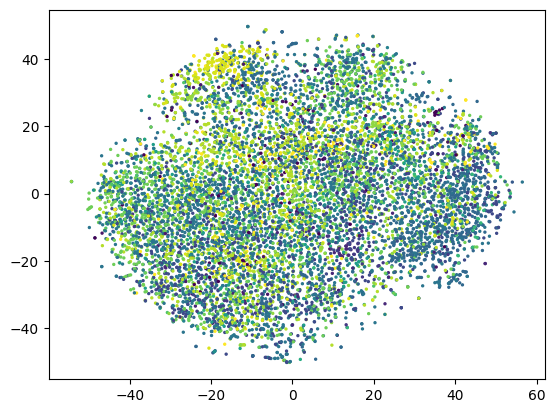

In [19]:
SAMPLE_COUNT = 10000

tsne = TSNE()
embedded_u = tsne.fit_transform(x_train[:SAMPLE_COUNT, 1:])

y_train_class = np.zeros(shape=(SAMPLE_COUNT))
for i in range(SAMPLE_COUNT):
    genre = np.nonzero(y_train[i, :])
    y_train_class[i] = genre[0][-1]

plt.scatter(x=embedded_u[:, 0],
            y=embedded_u[:, 1],
            c=y_train_class,
            s=2.0)


Genre Model Training

In [20]:
model = tf.keras.Sequential(layers=[
    tf.keras.layers.InputLayer(input_shape=(x_train.shape[1] - 1)),
    tf.keras.layers.Dense(units=20,
                          activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=20,
                          activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=y_train.shape[1],
                          activation=tf.keras.activations.sigmoid),
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.binary_crossentropy)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                2020      
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 19)                399       
                                                                 
Total params: 2,839
Trainable params: 2,839
Non-trainable params: 0
_________________________________________________________________


2022-11-06 11:41:32.074423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-06 11:41:32.074870: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-06 11:41:32.074887: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (davis-MS-7A38): /proc/driver/nvidia/version does not exist
2022-11-06 11:41:32.076502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model.fit(x=x_train[:, 1:], 
          y=y_train,
          validation_data=(x_test[:, 1:], y_test),
          epochs=50)

Epoch 1/50
1318/1318 [==============================] - 1s 757us/step - loss: 0.2430 - val_loss: 0.2247
Epoch 2/50
1318/1318 [==============================] - 1s 684us/step - loss: 0.2227 - val_loss: 0.2251
Epoch 3/50
1318/1318 [==============================] - 1s 647us/step - loss: 0.2190 - val_loss: 0.2191
Epoch 4/50
1318/1318 [==============================] - 1s 658us/step - loss: 0.2176 - val_loss: 0.2145
Epoch 5/50
1318/1318 [==============================] - 1s 632us/step - loss: 0.2172 - val_loss: 0.2174
Epoch 6/50
1318/1318 [==============================] - 1s 663us/step - loss: 0.2166 - val_loss: 0.2160
Epoch 7/50
1318/1318 [==============================] - 1s 637us/step - loss: 0.2161 - val_loss: 0.2167
Epoch 8/50
1318/1318 [==============================] - 1s 633us/step - loss: 0.2163 - val_loss: 0.2168
Epoch 9/50
1318/1318 [==============================] - 1s 652us/step - loss: 0.2162 - val_loss: 0.2144
Epoch 10/50
1318/1318 [==============================] - 1s 651u

In [22]:
y_pred = model.predict(x_test[:, 1:])

330/330 [==============================] - 0s 369us/step


In [23]:
mu = np.mean(y_train, axis=0)
print(mu)

baseline = np.zeros(shape=(y_train.shape), dtype=np.float32)

for i in range(y_train.shape[0]):
    baseline[i, :] = np.random.binomial(n=1, p=mu, size=19)

baseline


[0.13382053 0.07566554 0.04873535 0.05113178 0.2966355  0.09481326
 0.09414891 0.44834623 0.04799981 0.00702321 0.10380582 0.00322688
 0.02116452 0.05144023 0.13873203 0.06346984 0.15562569 0.03407203
 0.02564893]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
def Recall(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    num_items = 0
    num_items_retrieved = 0

    for i in range(y_true.shape[0]):
        for j in range(y_true.shape[1]):
            if y_true[i, j] == 1:
                num_items += 1

                if y_pred[i, j] >= 0.5:
                    num_items_retrieved += 1
    
    return num_items_retrieved, num_items_retrieved/num_items


def Recall2(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    num_items = y_true.shape[0]
    num_items_retrieved = 0

    for i in range(y_true.shape[0]):
        has_match = False
        for j in range(y_true.shape[1]):    
            if y_true[i, j] == 1 and y_pred[i, j] >= 0.5:
                has_match = True
        
        if has_match:
            num_items_retrieved += 1

    return num_items_retrieved, num_items_retrieved/num_items

def Precision(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    num_tps = 0
    num_fps = 0

    for i in range(y_true.shape[0]):
        for j in range(y_true.shape[1]):
            if y_pred[i, j] >= 0.5:
                if y_true[i, j] == 1:
                    num_tps += 1
                else:
                    num_fps += 1

    return num_tps, num_tps/(num_tps + num_fps) if (num_tps + num_fps) > 0 else 0.0


def Precision2(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    num_tps = 0
    num_fps = 0

    for i in range(y_true.shape[0]):
        num_positives = np.sum(y_pred[i, :] >= 0.5)
        if num_positives == 0:
            continue

        all_matched = True
        for j in range(y_true.shape[1]):
            if y_pred[i, j] >= 0.5 and y_true[i, j] == 0:
                all_matched = False
        
        if all_matched:
            num_tps += 1
        else:
            num_fps += 1

    return num_tps, num_tps/(num_tps + num_fps) if num_tps + num_fps > 0 else 0.0


baseline_num_retrieved, baseline_recall = Recall(y_test, baseline)
baseline_num_tps, baseline_precision = Precision(y_test, baseline)
baseline_num_retrieved2, baseline_recall2 = Recall2(y_test, baseline)
baseline_num_tps2, baseline_precision2 = Precision2(y_test, baseline)

print("Baseline Recall={0} #Retrieved={1}".format(
    baseline_recall, baseline_num_retrieved))
print("Baseline Precision={0} #TruePositives={1}".format(
    baseline_precision, baseline_num_tps))
print("Baseline Recall2={0} #Retrieved={1}".format(
    baseline_recall2, baseline_num_retrieved2))
print("Baseline Precision2={0} #TruePositives={1}".format(
    baseline_precision2, baseline_num_tps2))

model_num_retrived, model_recall = Recall(y_test, y_pred)
model_num_tps, model_precision = Precision(y_test, y_pred)
model_num_retrieved2, model_recall2 = Recall2(y_test, y_pred)
model_num_tps2, model_precision2 = Precision2(y_test, y_pred)

print("Model Recall={0} #Retrieved={1}".format(
    model_recall, model_num_retrived))
print("Model Precision={0} #TruePositives={1}".format(
    model_precision, model_num_tps))
print("Model Recall2={0} #Retrieved={1}".format(
    model_recall2, model_num_retrieved2))
print("Model Precision2={0} #TruePositives={1}".format(
    model_precision2, model_num_tps2))


Baseline Recall=0.21465282676609895 #Retrieved=4260
Baseline Precision=0.21203523965954904 #TruePositives=4260
Baseline Recall2=0.36585365853658536 #Retrieved=3855
Baseline Precision2=0.09393094574308385 #TruePositives=876
Model Recall=0.2906882999093016 #Retrieved=5769
Model Precision=0.6251625487646294 #TruePositives=5769
Model Recall2=0.5145677137705229 #Retrieved=5422
Model Precision2=0.5969273045216088 #TruePositives=4779
